### Real Options Valuation and Monte Carlo simulation. DM and FPOM.

**This is the sheet for the pumped hydroelectric expansion case.**

Mapping MS Excel modeled calculations into Python for later implementation with Django. Note this file is separe from the main Django project, but checked in to be tracked within source control as a related project.  

**Note:** Remember to occasionally save to cloud alongside MS Word and Excel files. 

**Update:** Checked this file into RO-calc Django source control repository.

In [2]:
# Using conda interpreter -> import libraries
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
# Utility: converter from excel to numpy arrays

data_base_case = "-16,99 -16,50 6,82 6,38 5,96 5,57 5,21 4,87 4,55 4,25 3,97 3,71 3,47 3,24 3,03 2,83 2,65 2,47 2,31 2,16 2,02 1,89 1,76 1,65 1,54 1,44 1,35 1,26 1,18 1,10 1,03 0,96 0,90 0,84 0,78 0,73 0,68 0,64 0,60 0,56 0,52 0,49 0,46 0,43 0,40 0,37 0,35 0,32 0,30 0,28 0,27 0,25"
data_base_case = data_base_case.replace(",", ".")  # replace commas with dots for decimal numbers
data_base_case_list = data_base_case.split()  # split the string into a list of strings
data_base_case_floats = [float(x) for x in data_base_case_list]  # convert the list of strings into a list of floats
cash_flows_mode = np.array(data_base_case_floats)  # convert the list of floats into a numpy array

data_optimistic = "-14,56 -14,14 7,89 7,37 6,89 6,44 6,02 5,62 5,25 4,91 4,59 4,29 4,01 3,75 3,50 3,27 3,06 2,86 2,67 2,50 2,33 2,18 2,04 1,90 1,78 1,66 1,55 1,45 1,36 1,27 1,19 1,11 1,04 0,97 0,90 0,85 0,79 0,74 0,69 0,65 0,60 0,56 0,53 0,49 0,46 0,43 0,40 0,38 0,35 0,33 0,31 0,29"
data_optimistic = data_optimistic.replace(",", ".")  # replace commas with dots for decimal numbers
data_optimistic_list = data_optimistic.split()  # split the string into a list of strings
data_optimistic_floats = [float(x) for x in data_optimistic_list]  # convert the list of strings into a list of floats
cash_flows_high = np.array(data_optimistic_floats)  # convert the list of floats into a numpy array

data_pessimistic = "-19,42 -18,85 4,90 4,58 4,28 4,00 3,74 3,49 3,26 3,05 2,85 2,66 2,49 2,33 2,17 2,03 1,90 1,78 1,66 1,55 1,45 1,35 1,27 1,18 1,11 1,03 0,97 0,90 0,84 0,79 0,74 0,69 0,64 0,60 0,56 0,53 0,49 0,46 0,43 0,40 0,37 0,35 0,33 0,31 0,29 0,27 0,25 0,23 0,22 0,20 0,19 0,18"
data_pessimistic = data_pessimistic.replace(",", ".")  # replace commas with dots for decimal numbers
data_pessimistic_list = data_pessimistic.split()  # split the string into a list of strings
data_pessimistic_floats = [float(x) for x in data_pessimistic_list]  # convert the list of strings into a list of floats
cash_flows_low = np.array(data_pessimistic_floats)  # convert the list of floats into a numpy array

In [98]:
# Define the parameters for the Datar-Mathews method
num_simulations = 100000  # number of simulations

# Add a small amount to the high values and subtract a small amount from the low values when they are equal
epsilon = 0.0001
equal_indices = np.where(cash_flows_low == cash_flows_high)
cash_flows_low[equal_indices] -= epsilon
cash_flows_high[equal_indices] += epsilon

# Create a function to simulate a single run of the Datar-Matthews method
def datar_mathews_single_run(cash_flows_low, cash_flows_mode, cash_flows_high):
    cash_flows = np.random.triangular(cash_flows_low, cash_flows_mode, cash_flows_high, len(cash_flows_low))
    npv = sum(cash_flows)
    irr = npf.irr(cash_flows)
    return npv, irr

# Create a function to run the Monte Carlo simulation
def monte_carlo_simulation(cash_flows_low, cash_flows_mode, cash_flows_high, num_simulations):
    npvs = []
    irrs = []
    for _ in range(num_simulations):
        npv, irr = datar_mathews_single_run(cash_flows_low, cash_flows_mode, cash_flows_high)
        npvs.append(npv)
        irrs.append(irr)
    return npvs, irrs

# Run the Monte Carlo simulation and store the results
npvs, irrs = monte_carlo_simulation(cash_flows_low, cash_flows_mode, cash_flows_high, num_simulations)

# Analyze the results
npv_mean = np.mean(npvs)
npv_std = np.std(npvs)

### Let's visualize

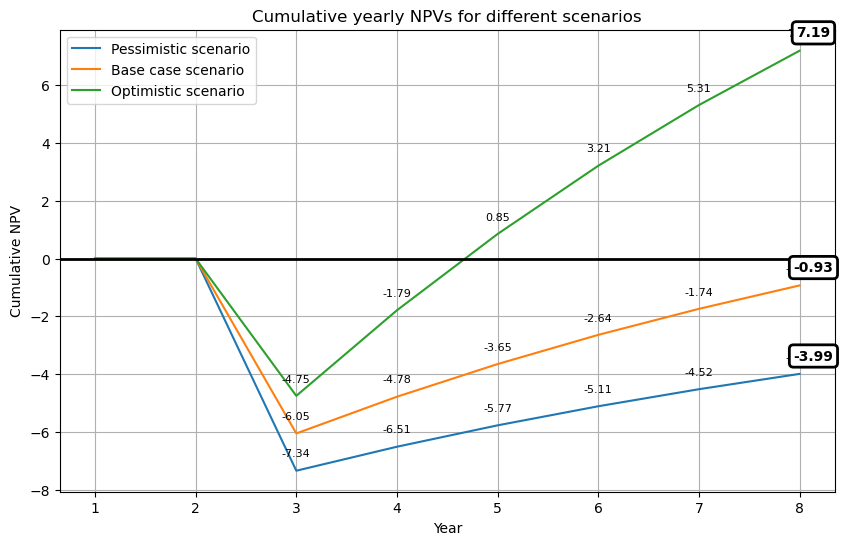

In [99]:
# For visualization, define years
years = range(1, len(cash_flows_low) + 1)

# Calculate cumulative cash flows
cumulative_cash_flows_low = np.cumsum(cash_flows_low)
cumulative_cash_flows_mode = np.cumsum(cash_flows_mode)
cumulative_cash_flows_high = np.cumsum(cash_flows_high)

# Plot cumulative cash flow scenarios
plt.figure(figsize=(10, 6))
plt.plot(years, cumulative_cash_flows_low, label='Pessimistic scenario')
plt.plot(years, cumulative_cash_flows_mode, label='Base case scenario')
plt.plot(years, cumulative_cash_flows_high, label='Optimistic scenario')

# Bolden the zero value on the y-axis
plt.axhline(0, color='black', linewidth=2)

# Define a threshold value as a quarter of the minimum non-zero NPV value
epsilon = 0.25

# Add annotations for each year's current cumulative total
for i, year in enumerate(years, start=1):
    if abs(cumulative_cash_flows_low[i-1]) > epsilon:
        plt.annotate(f'{cumulative_cash_flows_low[i-1]:.2f}', (year, cumulative_cash_flows_low[i-1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    if abs(cumulative_cash_flows_mode[i-1]) > epsilon:
        plt.annotate(f'{cumulative_cash_flows_mode[i-1]:.2f}', (year, cumulative_cash_flows_mode[i-1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    if abs(cumulative_cash_flows_high[i-1]) > epsilon:
        plt.annotate(f'{cumulative_cash_flows_high[i-1]:.2f}', (year, cumulative_cash_flows_high[i-1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Add original boxed annotations for final cumulative values
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)
plt.annotate(f'{cumulative_cash_flows_low[-1]:.2f}', (years[-1], cumulative_cash_flows_low[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
plt.annotate(f'{cumulative_cash_flows_mode[-1]:.2f}', (years[-1], cumulative_cash_flows_mode[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
plt.annotate(f'{cumulative_cash_flows_high[-1]:.2f}', (years[-1], cumulative_cash_flows_high[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)

plt.xlabel('Year')
plt.ylabel('Cumulative NPV')
plt.title('Cumulative yearly NPVs for different scenarios')
plt.legend()
plt.grid(True)
plt.show()

### Let's calculate the risk-adjusted ROV with the DM method

In [100]:
# Filter the NPVs to only include the positive ones
npvs_positive = [npv for npv in npvs if npv > 0]

# Calculate the mean of the positive NPVs
npv_positive_mean = np.mean(npvs_positive)

# Calculate the proportion of positive outcomes
proportion_positive = len(npvs_positive) / num_simulations

# Adjust the mean by the proportion of positive outcomes
npv_adjusted = npv_positive_mean * proportion_positive

print(f"The non-risk adjusted NPV is {npv_positive_mean}")
print(f"The risk-adjusted mean NPV is {npv_adjusted}")

The non-risk adjusted NPV is 1.139647089165481
The risk-adjusted mean NPV is 0.8769356421710545


### Let's visualize the outcome NPV distribution

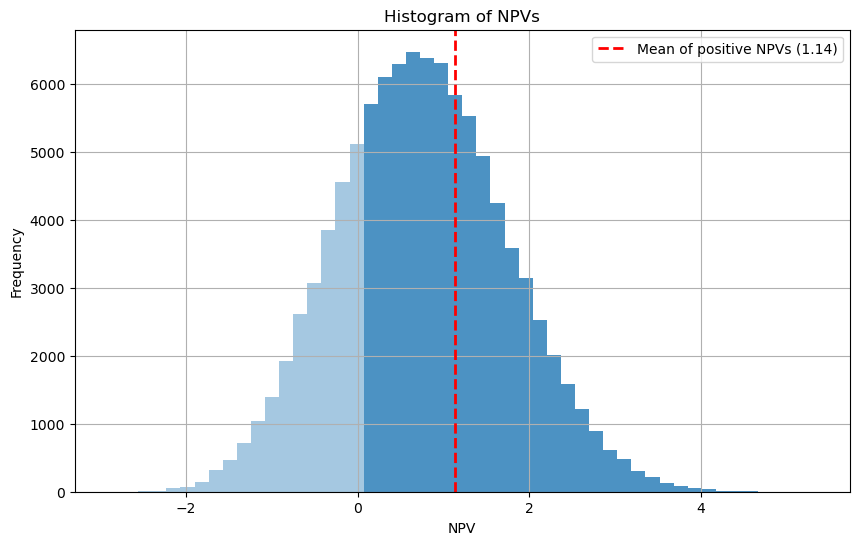

In [101]:
# Create a histogram of the NPVs
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(npvs, bins=50, alpha=0.8)

# Change the color of bars below zero
for count, bin, patch in zip(counts, bins, patches):
    if bin < 0:
        patch.set_alpha(0.4)  # Decrease the opacity

# Calculate the mean of the positive NPVs
npvs_positive = [npv for npv in npvs if npv > 0]
npv_positive_mean = np.mean(npvs_positive)

# Draw a vertical line at the mean value of the positive side of the distribution
plt.axvline(npv_positive_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean of positive NPVs ({npv_positive_mean:.2f})')

plt.xlabel('NPV')
plt.ylabel('Frequency')
plt.title('Histogram of NPVs')
plt.legend()
plt.grid(True)
plt.show()

### Calculating FPOM

In [102]:
pess = round(cumulative_cash_flows_low[-1], 2)
base = round(cumulative_cash_flows_mode[-1], 2)
opti = round(cumulative_cash_flows_high[-1], 2)

fpom_a = base

In [103]:
def calculate_fpom_alpha(pess, base):
    if pess < 0:
        return abs(pess) + abs(base)
    else:
        return abs(base) - abs(pess)
    
def calculate_fpom_beta(base, opti):
    if base < 0:
        return abs(opti) + abs(base)
    else:
        return abs(opti) - abs(base)
    
fpom_alpha = round(calculate_fpom_alpha(pess, base), 2)
fpom_beta = round(calculate_fpom_beta(base, opti), 2)

print(f"The FPOM alpha is {fpom_alpha}")
print(f"The FPOM beta is {fpom_beta}")

The FPOM alpha is 4.92
The FPOM beta is 8.12


In [104]:
def calculate_fpom_case_1():
    return 0

def calculate_fpom_case_2(fpom_a, fpom_beta):
    return round((fpom_a**3)/(6*fpom_beta**2) + (fpom_a**2)/(2*fpom_beta) + fpom_a/2 + fpom_beta/6, 2)

def calculate_fpom_case_3(fpom_a, fpom_alpha, fpom_beta):
    return round(-(fpom_a**3)/(6*fpom_alpha**2) + (fpom_a**2)/(2*fpom_alpha) + fpom_a/2 + fpom_beta/6, 2)

def calculate_fpom_case_4(fpom_a, fpom_alpha, fpom_beta):
    return round(fpom_a + (fpom_beta - fpom_alpha) / 6, 2)

In [105]:
def calculate_final_fpom_rov(pess, base, opti, fpom_a, fpom_alpha, fpom_beta):
    if pess <= 0 and base <= 0 and opti <= 0:
        return calculate_fpom_case_1()
    elif pess <= 0 and base <= 0 and opti > 0:
        return calculate_fpom_case_2(fpom_a, fpom_beta)
    elif pess <= 0 and base > 0 and opti > 0:
        return calculate_fpom_case_3(fpom_a, fpom_alpha, fpom_beta)
    elif pess > 0 and base > 0 and opti > 0:
        return calculate_fpom_case_4(fpom_a, fpom_alpha, fpom_beta)

In [106]:
print(f"Case 1: When none are above zero: {calculate_fpom_case_1()}")
print(f"Case 2: When only optimistic is above zero: {calculate_fpom_case_2(fpom_a, fpom_beta)}")
print(f"Case 3: When optimistic and base case are above zero: {calculate_fpom_case_3(fpom_a, fpom_alpha, fpom_beta)}")
print(f"Case 4: When all are above zero:  {calculate_fpom_case_4(fpom_a, fpom_alpha, fpom_beta)}")

Case 1: When none are above zero: 0
Case 2: When only optimistic is above zero: 0.94
Case 3: When optimistic and base case are above zero: 0.98
Case 4: When all are above zero:  -0.4


In [107]:
result = calculate_final_fpom_rov(pess, base, opti, fpom_a, fpom_alpha, fpom_beta)
print(f"Taking into account the correct case, final result is: {result}")

Taking into account the correct case, final result is: 0.94
